In [1]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as pp

%matplotlib inline

In [2]:
def compose_person(data):
    age, sex = data
    return 'Child' if age < 16 else sex.capitalize()

def compose_class(data):
    data = data[0]
    if data == 1: return 'Upper'
    elif data == 2: return 'Middle'
    elif data == 3: return 'Lower'
    else: raise 'Unknown class'

def denan(data, column):
    mean = data[column].mean()
    deviation = data[column].std()
    count = data[column].isnull().sum()
    rand = np.random.randint(mean - deviation, mean + deviation, size=count)
    data.loc[np.isnan(data[column]), column] = rand
    return count

def load(path, columns=['PassengerId', 'Survived', 'Age', 'Person', 'Class']):
    print('File: {}'.format(path))
    data = pd.read_csv(path)
    print('  Data points: {}'.format(data.size))
    print('  Unknown age: {}'.format(denan(data, 'Age')))
    data['Age'] = data['Age'].astype(int)
    data['Person'] = data[['Age', 'Sex']].apply(compose_person, axis=1)
    data['Class'] = data[['Pclass']].apply(compose_class, axis=1)
    data.drop(list(set(data.columns.values) - set(columns)), axis=1, inplace=True)
    return data

train_data = load('data/train.csv')
test_data = load('data/test.csv')
train_data.head(10)

File: data/train.csv
  Data points: 10692
  Unknown age: 177
File: data/test.csv
  Data points: 4598
  Unknown age: 86


,PassengerId,Survived,Age,Person,Class
0,1,0,22,Male,Lower
1,2,1,38,Female,Upper
2,3,1,26,Female,Lower
3,4,1,35,Female,Upper
4,5,0,35,Male,Lower
5,6,0,29,Male,Lower
6,7,0,54,Male,Upper
7,8,0,2,Child,Lower
8,9,1,27,Female,Lower
9,10,1,14,Child,Middle


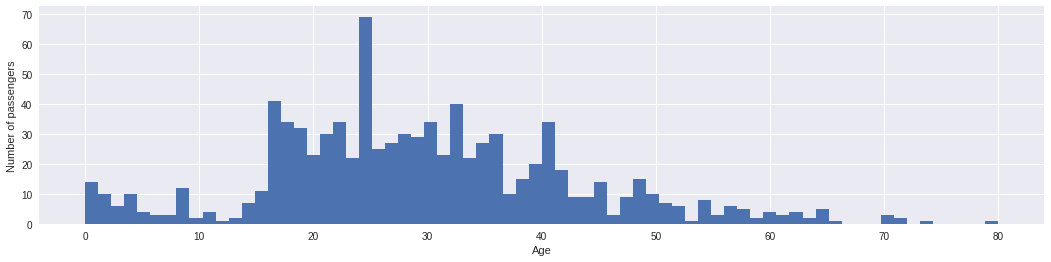

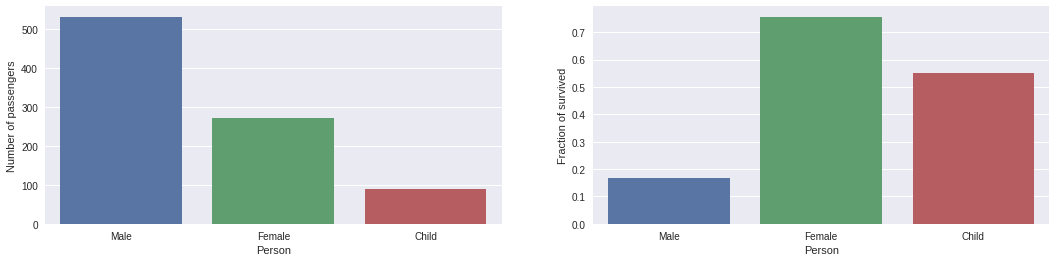

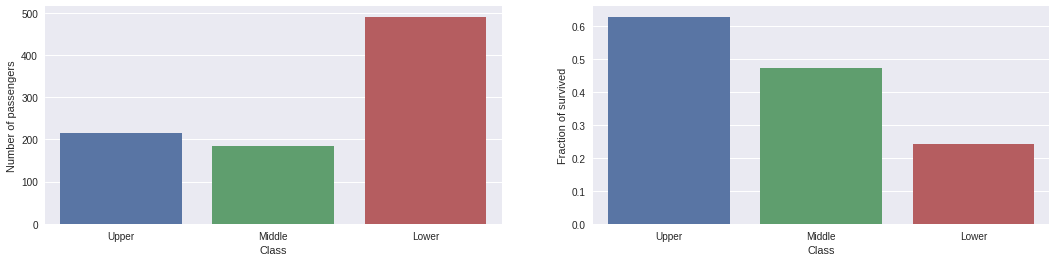

In [3]:
def plot_histogram(data, column):
    figure = pp.figure(figsize=(18, 4))
    data[column].hist(bins=70)
    pp.xlabel(column)
    pp.ylabel('Number of passengers')

def plot_survived(data, column, order):
    figure, axes = pp.subplots(1, 2, figsize=(18, 4))
    sb.countplot(x=column, data=data, ax=axes[0], order=order)
    data = data[[column, 'Survived']].groupby([column], as_index=False).mean()
    sb.barplot(x=column, y='Survived', data=data, ax=axes[1], order=order)
    axes[0].set_ylabel('Number of passengers')
    axes[1].set_ylabel('Fraction of survived')

plot_histogram(train_data, 'Age')
plot_survived(train_data, 'Person', ['Male', 'Female', 'Child'])
plot_survived(train_data, 'Class', ['Upper', 'Middle', 'Lower'])

In [4]:
from sklearn.ensemble import RandomForestClassifier

In [5]:
def make_dummies(data, mapping):
    for column in mapping:
        dummies = pd.get_dummies(data[column])
        dummies.columns = mapping[column]
        data = data.join(dummies)
    data.drop(mapping.keys(), inplace=True, axis=1)
    return data

mapping = {
    'Person': ['Male', 'Female', 'Child'],
    'Class': ['Upper', 'Middle', 'Lower'],
}

train_data = make_dummies(train_data, mapping)
test_data = make_dummies(test_data, mapping)

train_data.head(10)

,PassengerId,Survived,Age,Male,Female,Child,Upper,Middle,Lower
0,1,0,22,0,0,1,1,0,0
1,2,1,38,0,1,0,0,0,1
2,3,1,26,0,1,0,1,0,0
3,4,1,35,0,1,0,0,0,1
4,5,0,35,0,0,1,1,0,0
5,6,0,29,0,0,1,1,0,0
6,7,0,54,0,0,1,0,0,1
7,8,0,2,1,0,0,1,0,0
8,9,1,27,0,1,0,1,0,0
9,10,1,14,1,0,0,0,1,0


In [6]:
X_train = train_data.drop(['PassengerId', 'Survived'], axis=1)
Y_train = train_data['Survived']
X_test  = test_data.drop('PassengerId', axis=1)

In [7]:
model = RandomForestClassifier(n_estimators=100)
model.fit(X_train, Y_train)
print('Score: {}'.format(model.score(X_train, Y_train)))

Score: 0.8686868686868687


In [8]:
data = pd.DataFrame({
    'PassengerId': test_data['PassengerId'],
    'Survived': model.predict(X_test),
})
data.to_csv('solution.csv', index=False)